# Loop Hydrodynamics
Configure loop hydrodynamics with HYDRAD. We need to write an interface to the HYDRAD model that can both configure the simulations and load the results back in

In [35]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import astropy.units as u
import astropy.constants as const
import sunpy.sun.constants as sun_const
from scipy.interpolate import splrep,splev

from hydrad_tools.configure import Configure

import synthesizAR
from synthesizAR.interfaces.ebtel import power_law_transform,calculate_free_energy


%matplotlib inline

In [2]:
active_region = synthesizAR.Field.restore('/storage-home/w/wtb2/data/hi_c_simulation/noaa12712_base/')

## HYDRAD Interface
The first thing we need to do is set up an interface to HYDRAD.

In [20]:
class HYDRADInterface(object):
    
    def __init__(self,base_config,hydrad_dir,output_dir):
        self.name = 'HYDRAD'
        self.base_config = base_config
        self.hydrad_dir = hydrad_dir
        self.output_dir = output_dir
        self.duration = 200.0 * u.s
        self.stress = 0.3
        self.max_grid_cell = 1e8*u.cm
    
    def configure_input(self,loop):
        config = self.base_config.copy()
        # General configuration
        config['general']['loop_length'] = loop.full_length
        config['initial_conditions']['heating_location'] = loop.full_length / 2.
        config['grid']['minimum_cells'] = int(loop.full_length / self.max_grid_cell)
        # Gravity and cross-section coefficients
        config['general']['tabulated_gravity_profile'] = self.get_gravity_coefficients(loop)
        config['general']['tabulated_cross_section_profile'] = self.get_cross_section_coefficients(loop)
        # Heating configuration
        events = []
        rates = self.get_heating_rates(loop)
        twaits = self.get_waiting_times(rates)
        cumulative_time = 0*u.s
        for r,t in zip(rates,twaits):
            events.append({
                'time_start': cumulative_time.copy(),
                'rise_duration': self.duration/2.,
                'decay_duration': self.duration/2.,
                'total_duration': self.duration,
                'location': loop.full_length / 2.,
                'scale_height': 1e300*u.cm,
                'rate': r,
            })
            cumulative_time += t + self.duration
        # Set the heating events here
        config['heating']['events'] = events
        # Setup configuration, run IC code
        c = Configure(config)
        c.setup_simulation(self.output_dir,base_path='/storage-home/w/wtb2/codes/HYDRAD/',name=loop.name,verbose=False)
    
    def load_results(self,loop):
        # return time, electron_temperature, ion_temperature, density, velocity
        pass
    
    def get_cross_section_coefficients(self, loop):
        s_norm = loop.field_aligned_coordinate / loop.full_length
        return np.polyfit(s_norm, loop.field_strength, 6)[::-1]
    
    def get_gravity_coefficients(self, loop):
        s_norm = loop.field_aligned_coordinate / loop.full_length
        s_hat_r = np.gradient(loop.coordinates.spherical.distance,) / loop.coordinates.spherical.norm()
        g_parallel = -sun_const.surface_gravity.cgs * ((const.R_sun.cgs / loop.coordinates.spherical.distance)**2) * s_hat_r
        return np.polyfit(s_norm, g_parallel, 6)[::-1]
    
    def get_average_waiting_time(self,loop):
        # Approximate the loop cooling time
        return loop.full_length / (80*u.Mm) * 4000*u.s 
    
    def get_number_events(self,loop):
        twait = self.get_average_waiting_time(loop)
        return int(np.ceil(base_config['general']['total_time'] / (self.duration + twait)))
    
    def get_heating_rates(self,loop):
        rate_max = (self.stress * loop.field_strength.max().value)**2 / (8.*np.pi) * u.erg / (u.cm**3)
        rate_max /= (self.duration / 2.)
        rate_min = rate_max / 100.0
        return power_law_transform(np.random.rand(self.get_number_events(loop)), rate_min, rate_max, -2.5) 
    
    def get_waiting_times(self, rates):
        prop_const = (self.base_config['general']['total_time'] - rates.shape[0] * self.duration) / rates.sum()
        return rates * prop_const


## Configure Loop Simulations

First, setup a base configuration dictionary. These are the options that won't change from loop to loop.

In [21]:
base_config = {
    'general': {
        'total_time': 5e4 * u.s,
        #'loop_length': 80 * u.Mm,
        'footpoint_height': 5e8 * u.cm,
        'output_interval': 5*u.s,
        'loop_inclination': 0*u.deg,
        'logging_frequency': 1000,
        'write_file_physical': True,
        'write_file_ion_populations': False,
        'write_file_hydrogen_level_populations': False,
        'write_file_timescales': False,
        'write_file_equation_terms': False,
        'heat_flux_limiting_coefficient': 1./6.,
        'heat_flux_timestep_limit': 1e-10*u.s,
        'use_kinetic_model': False,
        'minimum_collisional_coupling_timescale': 0.01*u.s,
        'force_single_fluid': False,
        #'tabulated_gravity_profile':,
        #'tabulated_cross_section_profile':,
    },
    'initial_conditions': {
        'footpoint_temperature': 2e4 * u.K,
        'footpoint_density': 1e11 * u.cm**(-3),
        'isothermal': False,
        #'heating_location':,
        'heating_scale_height': 1e300*u.cm,
        'heating_range_lower_bound': 1e-8*u.erg/u.s/(u.cm**3),
        'heating_range_upper_bound': 1e2*u.erg/u.s/(u.cm**3),
        'heating_range_step_size': 0.01,
        'heating_range_fine_tuning': 10000.0,
        'use_tabulated_gravity': False,
    },
    'radiation': {
        'use_power_law_radiative_losses': True,
        'decouple_ionization_state_solver': False,
        'density_dependent_rates': False,
        'optically_thick_radiation': False,
        'nlte_chromosphere': False,
        'ranges_dataset': 'ranges',
        'emissivity_dataset': 'chianti_v7',
        'abundance_dataset': 'asplund',
        'rates_dataset': 'chianti_v7',
        'elements_equilibrium': ['Fe'],
        'elements_nonequilibrium': [],
    },
    'heating': {
        'heat_electrons': True,
        'background_heating': True,
        'beam_heating': False,
        'alfven_wave_heating': False,
        #'events': [
        #    {'time_start': 0.*u.s, 
        #     'rise_duration': 100*u.s,
        #     'decay_duration': 100*u.s, 
        #     'total_duration': 200*u.s,
        #     'location': 4e9*u.cm, 
        #     'scale_height': 1e300 * u.cm,
        #     'rate': 0.1 *u.erg/u.s/(u.cm**3),},
        #],
    },
    'solver': {
        'epsilon': 0.01,
        'safety_radiation': 0.1,
        'safety_conduction': 1.0,
        'safety_advection': 1.0,
        'safety_atomic': 1.0,
        'safety_viscosity': 1.0,
        'cutoff_ion_fraction':1e-6,
        'epsilon_d':0.1,
        'epsilon_r':1.8649415311920072,
        'timestep_increase_limit': 5*u.percent,
        'relative_viscous_timescale': None,
        'minimum_radiation_temperature': 2e4*u.K,
        'zero_over_temperature_interval': 5.0e2*u.K,
        'minimum_temperature': 1e4*u.K,
        'maximum_optically_thin_density': 1e12*u.cm**(-3),
    },
    'grid': {
        'adapt': True,
        'adapt_every_n_time_steps': 10,
        #'minimum_cells': 150,
        'maximum_cells': 30000,
        'maximum_refinement_level': 12,
        'minimum_delta_s': 1.0*u.cm,
        'maximum_variation': 10*u.percent,
        'refine_on_density': True,
        'refine_on_electron_energy': True,
        'refine_on_hydrogen_energy': False,
        'minimum_fractional_difference': 10*u.percent,
        'maximum_fractional_difference': 20*u.percent,
        'linear_restriction': True,
        'enforce_conservation': False,
    }
} 


In [22]:
interface = HYDRADInterface(base_config, '/storage-home/w/wtb2/codes/HYDRAD/',
                            '/storage-home/w/wtb2/data/hi_c_simulation/hydrodynamics/')

In [18]:
interface.configure_input(active_region.loops[0])




In file included from ../source/misc.cpp:22:0:
../source/../../Resources/Utils/regPoly/nrutil.h:4:15: warning: ‘sqrarg’ defined but not used [-Wunused-variable]
 static double sqrarg;
               ^
../source/../../Resources/Utils/regPoly/nrutil.h:7:15: warning: ‘dsqrarg’ defined but not used [-Wunused-variable]
 static double dsqrarg;
               ^
../source/../../Resources/Utils/regPoly/nrutil.h:10:15: warning: ‘dmaxarg1’ defined but not used [-Wunused-variable]
 static double dmaxarg1,dmaxarg2;
               ^
../source/../../Resources/Utils/regPoly/nrutil.h:10:24: warning: ‘dmaxarg2’ defined but not used [-Wunused-variable]
 static double dmaxarg1,dmaxarg2;
                        ^
../source/../../Resources/Utils/regPoly/nrutil.h:14:15: warning: ‘dminarg1’ defined but not used [-Wunused-variable]
 static double dminarg1,dminarg2;
               ^
../source/../../Resources/Utils/regPoly/nrutil.h:14:24: warning: ‘dminarg2’ defined but not used [-Wunused-variable]
 static do

In [24]:
g_coeff = interface.get_gravity_coefficients(active_region.loops[0])
s_over_L = active_region.loops[0].field_aligned_coordinate / active_region.loops[0].full_length

In [27]:
g_loop = np.array([c*(s_over_L)**i for i,c in enumerate(g_coeff)]).sum(axis=0)

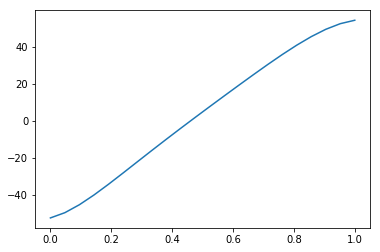

In [31]:
plt.plot(s_over_L,g_loop)

In [34]:
active_region.loops[0].coordinates.spherical.distance

<Distance [6.97657907e+10, 6.99001505e+10, 7.00241340e+10, 7.01353267e+10,
           7.02326372e+10, 7.03149959e+10, 7.03816512e+10, 7.04322425e+10,
           7.04669957e+10, 7.04857404e+10, 7.04887290e+10, 7.04760912e+10,
           7.04480972e+10, 7.04049420e+10, 7.03471138e+10, 7.02745920e+10,
           7.01881873e+10, 7.00883184e+10, 6.99762798e+10, 6.98535832e+10,
           6.97224046e+10, 6.95846207e+10] cm>

In [32]:
sun_const.surface_gravity.cgs

<Quantity 27400. cm / s2>

In [39]:
np.sqrt(loop000.coordinates.x**2 + loop000.coordinates.y**2 + loop000.coordinates.z**2)

<Quantity [6.97657907e+10, 6.99001505e+10, 7.00241340e+10, 7.01353267e+10,
           7.02326372e+10, 7.03149959e+10, 7.03816512e+10, 7.04322425e+10,
           7.04669957e+10, 7.04857404e+10, 7.04887290e+10, 7.04760912e+10,
           7.04480972e+10, 7.04049420e+10, 7.03471138e+10, 7.02745920e+10,
           7.01881873e+10, 7.00883184e+10, 6.99762798e+10, 6.98535832e+10,
           6.97224046e+10, 6.95846207e+10] cm>

In [40]:
loop000.coordinates.spherical.distance

<Distance [6.97657907e+10, 6.99001505e+10, 7.00241340e+10, 7.01353267e+10,
           7.02326372e+10, 7.03149959e+10, 7.03816512e+10, 7.04322425e+10,
           7.04669957e+10, 7.04857404e+10, 7.04887290e+10, 7.04760912e+10,
           7.04480972e+10, 7.04049420e+10, 7.03471138e+10, 7.02745920e+10,
           7.01881873e+10, 7.00883184e+10, 6.99762798e+10, 6.98535832e+10,
           6.97224046e+10, 6.95846207e+10] cm>

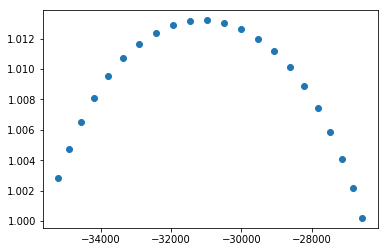

In [84]:
plt.plot(loop000.coordinates.spherical.lon.to(u.arcsec),loop000.coordinates.spherical.distance/const.R_sun.cgs,'o')

(69570000000.0, 72570000000.0)

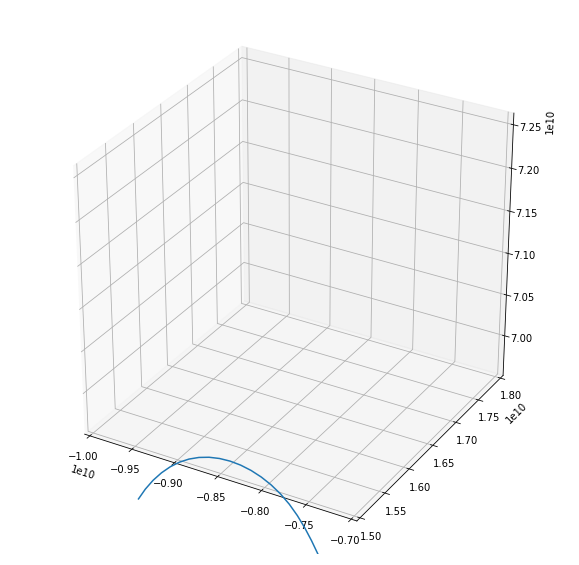

In [78]:
fig = plt.figure(figsize=(10,10))
ax = fig.gca(projection='3d')
loop000 = active_region.loops[0]
ax.plot(loop000.coordinates.y,loop000.coordinates.z,loop000.coordinates.x)
ax.set_xlim(-1e10,-0.7e10)
ax.set_ylim(1.5e10,1.8e10)
ax.set_zlim(const.R_sun.cgs.value,const.R_sun.cgs.value+0.3e10)

In [63]:
np.gradient(loop000.coordinates.spherical.distance).to(u.Mm)

<Distance [ 1.34359777,  1.29171623,  1.17588124,  1.04251634,  0.89834595,
            0.74506957,  0.58623274,  0.42672287,  0.26748953,  0.10866621,
           -0.04824601, -0.20315889, -0.35574571, -0.50491721, -0.65175019,
           -0.79463232, -0.93136803, -1.0595375 , -1.17367588, -1.26937576,
           -1.34481281, -1.37783965] Mm>

In [61]:
np.linalg.norm(grad_xyz, axis=0)

array([1.66664658e+08, 1.66522923e+08, 1.66568259e+08, 1.66594747e+08,
       1.66647656e+08, 1.66658229e+08, 1.66662295e+08, 1.66630734e+08,
       1.66594642e+08, 1.66573044e+08, 1.66567672e+08, 1.66570020e+08,
       1.66576339e+08, 1.66597158e+08, 1.66594399e+08, 1.66601257e+08,
       1.66600497e+08, 1.66602187e+08, 1.66606123e+08, 1.66611355e+08,
       1.66622257e+08, 1.25009159e+08, 8.33538160e+07])

In [57]:
s_norm = loop000.field_aligned_coordinate / loop000.full_length
grad_xyz = np.gradient(loop000.coordinates.cartesian.xyz,axis=1)
s_hat_r = np.gradient(loop000.coordinates.spherical.distance) / np.linalg.norm(grad_xyz, axis=0)
g_parallel = -sun_const.surface_gravity.cgs * ((const.R_sun.cgs / loop000.coordinates.spherical.distance)**2) * s_hat_r
g_coeff = np.polyfit(s_norm, g_parallel, 6)[::-1]

In [59]:
s_hat[0,:].value

array([ 1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1., -1., -1., -1.,
       -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.])

In [49]:
g_parallel

<Quantity [-5.99599408e+01, -5.87946512e+01, -5.64443817e+01,
           -5.31589018e+01, -4.90142270e+01, -4.42380990e+01,
           -3.89830799e+01, -3.35286820e+01, -2.79720851e+01,
           -2.23374952e+01, -1.66722539e+01, -1.10138299e+01,
           -5.45944302e+00,  6.59038750e-03,  5.34587070e+00,
            1.05583367e+01,  1.56310746e+01,  2.05366495e+01,
            2.52665907e+01,  2.98205953e+01,  3.41540852e+01,
            3.82542462e+01,  4.20788762e+01,  4.54364210e+01,
            4.82189204e+01,  5.05263209e+01,  5.26912057e+01,
            5.48126605e+01,  4.21991231e+01,  2.84731387e+01] cm / s2>

In [44]:
-sun_const.surface_gravity.cgs * ((const.R_sun.cgs / loop000.coordinates.spherical.distance)**2)

<Quantity [-27246.42507118, -27141.78136976, -27045.75296021,
           -26960.06408842, -26885.40707175, -26822.46316225,
           -26771.682584  , -26733.23630966, -26706.87396834,
           -26692.67124221, -26690.40786093, -26699.98097254,
           -26721.20475996, -26753.97265371, -26797.97652408,
           -26853.31483564, -26919.47073867, -26996.24052897,
           -27082.75678634, -27177.98108699, -27280.34483256,
           -27388.4869888 ] cm / s2>

In [43]:
s_hat_r

<Quantity [ 1.92586905e-03,  1.84794485e-03,  1.67925138e-03,
            1.48643543e-03,  1.27910040e-03,  1.05961688e-03,
            8.32934056e-04,  6.05862956e-04,  3.79595475e-04,
            1.54167655e-04, -6.84449997e-05, -2.88266398e-04,
           -5.04975605e-04, -7.17161602e-04, -9.26477509e-04,
           -1.13075337e-03, -1.32695837e-03, -1.51171769e-03,
           -1.67724818e-03, -1.81719491e-03, -1.92881014e-03,
           -1.98009221e-03]>

## Load in HYDRAD Results